In [1]:
from imutils.perspective import four_point_transform, order_points
from skimage.filters import threshold_local
import numpy as np
import argparse
import cv2
import imutils
import matplotlib.pyplot as plt

'''for video stramening'''
from imutils.video import FileVideoStream
from imutils.video import VideoStream
from imutils.video import FPS
import time

'''filter documets frm noise'''
from sklearn.cluster import DBSCAN

## Scan Document from web cam

In [2]:
def filter_approx(pts):
    """
    return the poins if the rectangle is valid and if its faced to the camerta
    """
    
    '''verify if the rectangle is not too long'''
    (x, y, w, h) = cv2.boundingRect(pts)
    ar = w / float(h) if w>h else h / float(w)
    if ar < 4:
        
        '''faced to the camerta'''
        rect = order_points(pts.reshape(4, 2))
        (tl, tr, br, bl) = rect

        widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
        widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
        maxWidth = max(int(widthA), int(widthB))
        minWidth = min(int(widthA), int(widthB)) + 0.00001

        heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
        heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
        maxHeight = max(int(heightA), int(heightB))
        minHeight = max(int(heightA), int(heightB)) + 0.00001

        if(maxWidth/minWidth<2.5 and maxHeight/minHeight<2.5):
            return pts

In [3]:
def detect_document(image):
    """
    Extracts tries to extrat the document location
    """
    
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)
    edged = cv2.Canny(gray, 55, 200)
    
    cnts = cv2.findContours(edged.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    if len(cnts) > 0:
        cnts = sorted(cnts, key = cv2.contourArea, reverse = True)[:5]
        for c in cnts:
            '''approximate the contour'''
            peri = cv2.arcLength(c, True)
            approx = cv2.approxPolyDP(c, 0.02 * peri, True)

            '''if our approximated contour has four points, then we can assume that we have found our screen'''
            if len(approx) == 4:
                return filter_approx(approx)

In [21]:
def not_valid_shape(shape):
    return max(shape)/min(shape) > 4

In [22]:
def scan_from_frame(frame):
    '''
    crops the document from each frame
    '''
    screenCnt = detect_document(frame)
    if not(np.any(screenCnt)):
        return None
    
    warped = four_point_transform(frame, screenCnt.reshape(4, 2))
    warped = cv2.cvtColor(warped, cv2.COLOR_BGR2GRAY)
    
    '''filter by shape'''
    if not_valid_shape(warped.shape):
        cv2.drawContours(frame, [screenCnt], -1, (0, 0, 255), 2)
    else:     
        cv2.drawContours(frame, [screenCnt], -1, (0, 255, 0), 2)

#         T = threshold_local(warped, 11, offset = 10, method = "gaussian")
#         warped = (warped > T).astype("uint8") * 255
        return warped

In [23]:
def scan_on_streaming(n_samples=1000):
    """
    This function starts the screaming object;
    And from each frame tries to extract the document scan;
    """
    scans = list()
    
    print('[INFO] Starting video stream...')
    vs = VideoStream(src=0).start()
    time.sleep(2.0)

    '''start the FPS throughput estimator'''
    fps = FPS().start()
    encodings = []
    labelSet = set()


    '''loop over frames from the video file stream'''
    try:
        while True:
            '''grab the frame from the threaded video stream'''
            frame = vs.read()
#             frame = imutils.resize(frame, width=500)
#             rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            
            """SCAN FROM FRAME"""
            scaned = scan_from_frame(frame)
            if np.any(scaned):
                if len(scans)>n_samples:
                    scans.pop(0)
                scans += [imutils.resize(scaned, height = 650)]
                    
            '''update the FPS counter'''
            fps.update()
            cv2.imshow("Frame", frame)
            key = cv2.waitKey(1) & 0xFF
            
            '''stop scan'''
            if key == ord("q"): break
                
#     '''Stop Some processes'''
#     except: pass 
    finally:
        fps.stop()
        cv2.destroyAllWindows()
        vs.stop()

    '''feed back'''
    print(f'[INFO] elasped time: {fps.elapsed():.2f}')
    print(f'[INFO] approx. FPS: {fps.fps():.2f}')
    return scans

## Colect Scaned Samples

In [31]:
scans = scan_on_streaming(n_samples=1000) # Colect sampl?

[INFO] Starting video stream...
[INFO] elasped time: 8.35
[INFO] approx. FPS: 210.90


## Filter Images

In [32]:
shapes = [scan.shape for scan in scans]

In [33]:
db = DBSCAN(eps=20, min_samples=50, metric='euclidean').fit(shapes)
# core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
# core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

In [34]:
def most_common(lst):
    return max(set(lst), key=list(lst).count)
most_common_label = most_common(labels)

In [35]:
scans = [scan for label,scan in zip(labels,scans) if label==most_common_label and label>-1]

## Show some samples

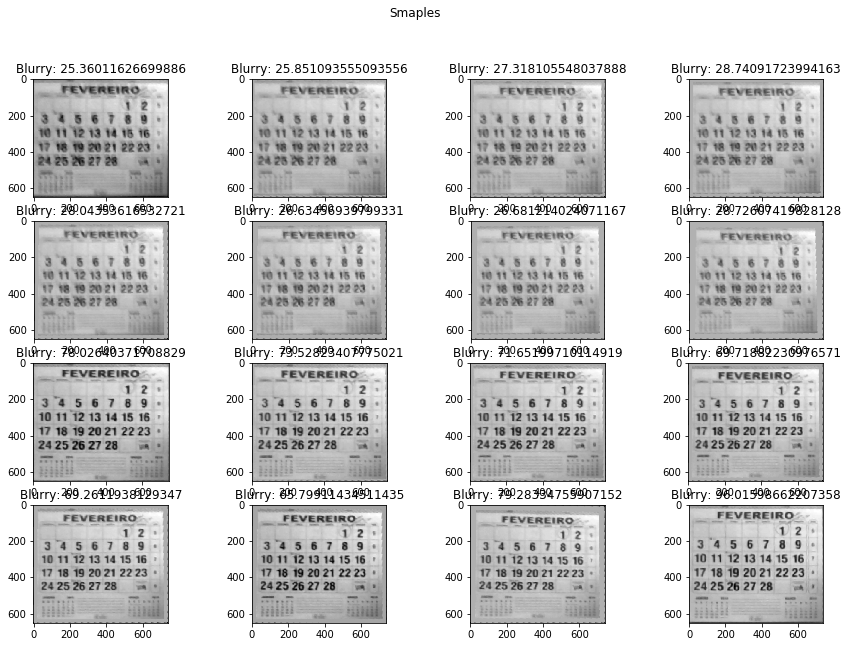

In [36]:
n = 4

plt.figure(figsize=(15,10))
plt.suptitle('Smaples')


for i,img in enumerate(scans[:n**2]):
    try:
        '''calculate how blurry is the scaned sample'''
        blurry = cv2.Laplacian(img, cv2.CV_64F).var()

        '''plot'''
        plt.subplot(n,n,(i+1))
        plt.title(f'Blurry: {blurry}')
        plt.imshow(img, cmap='gray')
    except:
        break
        
plt.show()

## Find the less blurry image

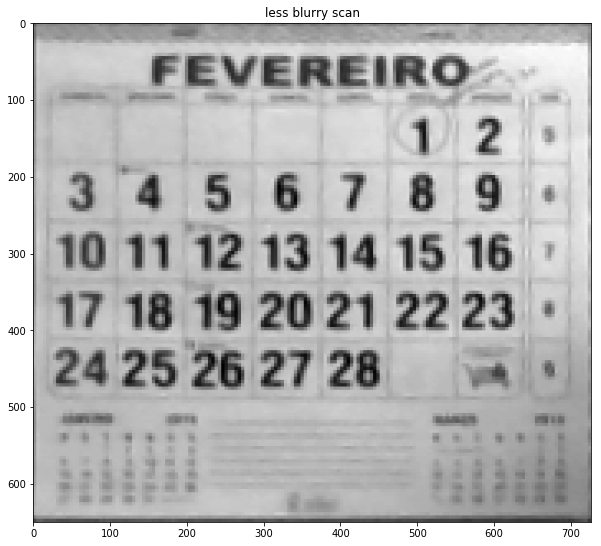

In [37]:
blurry = [cv2.Laplacian(img, cv2.CV_64F).var() for img in scans] 
less_blurry = max(blurry) ## the less blurry image has the max laplacian value
less_blurry_scan = scans[blurry.index(less_blurry)]

plt.figure(figsize=(10,10))
plt.title('less blurry scan')
plt.imshow(less_blurry_scan, cmap='gray')
plt.show()